In [1]:
"""
Importing dataset. 
"""
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random
from PIL import Image 
from torch.utils.data import DataLoader, Dataset
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import torch.optim as optim
import wandb
import timm
from torchvision.models import swin_t, Swin_T_Weights

/Users/kovarthanan/Acedamic/City, University of London/INM705 - Image Analysis/AI-Generated-Image-Detector/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting up the root folder
root_folder = "Dataset/"

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")  # if no GPU, then CPU

print("Device Running on:", device)

Device Running on: mps


In [4]:
# importing dataset 
df = pd.read_csv(root_folder+"subset_train.csv")

In [5]:
df.head()

,Unnamed: 0,file_name,label
0,7230,subset_train_data/872586102a8e44738ca8fa97046c...,1
1,3021,subset_train_data/5ba3fef1f8cb42cea0d3f43b98e6...,0
2,49745,subset_train_data/0f1ed6e90603411a89122c6de6e9...,0
3,60079,subset_train_data/f6422ac852aa4ab2a30ef9db7196...,0
4,3465,subset_train_data/0a7b016a42f14e1d9ba7fa98953c...,0


In [6]:
print(df['label'].value_counts())

label
0    6000
1    4000
Name: count, dtype: int64


This dataset contains 6000 real images and 4000 AI genertaed images. 

In [7]:
def show_random_image(df):
    """
    Display a random image from the dataset with its label.
    """

    # Choosing the random index
    index = random.randint(0, len(df) - 1)

    # Loading path and label
    file_name = df.iloc[index]['file_name']
    label = df.iloc[index]['label']

    # Load the image 
    image = Image.open(root_folder + file_name).convert('RGB')

    # Convert label
    label_text = "Real" if label == 0 else "AI-Generated"

    # Visualization
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Label: {label_text}", fontsize=14, color="red")
    plt.show()

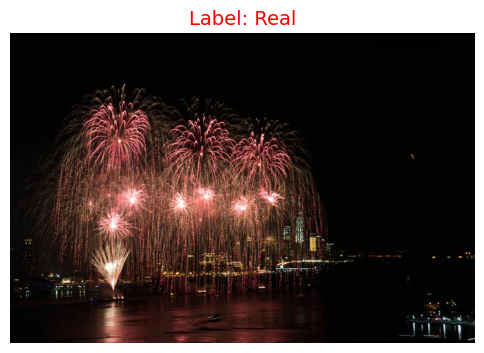

In [8]:
show_random_image(df)

In [9]:
""" 
Splitting dataset for training and testing
 - test_size = 20% 
"""
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [28]:
print(train_df['label'].value_counts())

label
0    4815
1    3185
Name: count, dtype: int64


In [11]:
print(val_df['label'].value_counts())

label
0    1185
1     815
Name: count, dtype: int64


In [12]:
# Setting up batch size
batch_size = 32

# CNN with Frequency Domain - Model 1

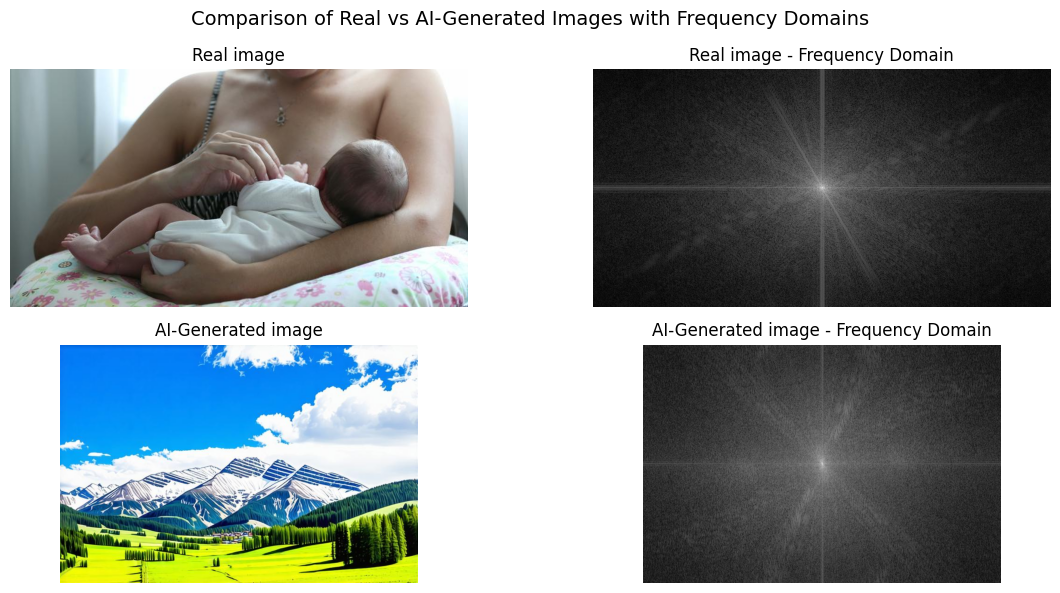

In [10]:
""" Visualize FFT for the randomly selected real and AI generated images """

def get_magnitude_spectrum(img_tensor):
    freq = torch.fft.fft2(img_tensor)
    freq_shifted = torch.fft.fftshift(freq)
    magnitude = torch.abs(freq_shifted)
    log_magnitude = torch.log1p(magnitude)
    return log_magnitude


def load_and_process_image(df, label_value, label_name, image_dir):
    # Filter for the label (0 = Human, 1 = AI)
    subset = df[df['label'] == label_value].reset_index(drop=True)
    sample = subset.sample(n=1).iloc[0]
    image_path = os.path.join(image_dir, os.path.basename(sample['file_name']))

    # Load image
    image = Image.open(image_path).convert('RGB')
    tensor = TF.to_tensor(image)
    magnitude_tensor = get_magnitude_spectrum(tensor)
    # Convert to grayscale
    magnitude_np = magnitude_tensor.mean(0).numpy()

    return image, magnitude_np, label_name, os.path.basename(image_path)

# Setting up directory 
image_dir = root_folder + "/subset_train_data"

# Load one Real and one AI-generated image
real_img, real_fft, real_label, real_name = load_and_process_image(
    train_df, label_value=0, label_name="Real", image_dir=image_dir)
fake_img, fake_fft, fake_label, fake_name = load_and_process_image(
    train_df, label_value=1, label_name="AI-Generated", image_dir=image_dir)


plt.figure(figsize=(12, 6))

# Real Image
plt.subplot(2, 2, 1)
plt.imshow(real_img)
plt.title(f"{real_label} image")
plt.axis("off")

# FFT of Real Image
plt.subplot(2, 2, 2)
plt.imshow(real_fft, cmap="gray")
plt.title(f"{real_label} image - Frequency Domain")
plt.axis("off")

# AI Generated Image
plt.subplot(2, 2, 3)
plt.imshow(fake_img)
plt.title(f"{fake_label} image")
plt.axis("off")

# FFT of AI Generated Image
plt.subplot(2, 2, 4)
plt.imshow(fake_fft, cmap="gray")
plt.title(f"{fake_label} image - Frequency Domain")
plt.axis("off")

plt.suptitle(
    "Comparison of Real vs AI-Generated Images with Frequency Domains", fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
class CNN_FD_Dataset(Dataset):
    """  
        A Custom PyTorch Dataset to load images and labels from the dataset. 
        Converting the images to the frequency domain using FFT. 
    """
    def __init__(self, dataframe, image_dir, transform=None, file_name_col='file_name', label_col='label'):
        """ 
            Arguments : 
                dataframe - imported dataset. 
                image_dir - directory of image dataset
                transform - transformation for image
                file_name_col - column name of the image path from dataset
                label_col - column name of the labels (real or fake) from dataset
        """
        self.dataframe = dataframe
        self.transform = transform
        self.image_dir = image_dir
        self.file_name_col = file_name_col
        self.label_col = label_col

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        """ 
            Processing one sample using image and corresponing labels. 
        """

        # Retriving the image name and forming the image path. 
        img_file = os.path.basename(
            self.dataframe.iloc[idx][self.file_name_col])
        img_path = os.path.join(self.image_dir, img_file)

        # Retriving the label. If not present assigning -1. 
        label = self.dataframe.iloc[idx][self.label_col] if self.label_col in self.dataframe.columns else -1

        image = Image.open(img_path).convert('RGB')
        image = TF.to_tensor(image)

        # Applying the transformation for the images before FFT converstion (Optional). 
        if self.transform:
            image = self.transform(image)

        # Transforming image to FFT
        freq_image = self._get_magnitude_spectrum(image)

        return freq_image, label

    def _get_magnitude_spectrum(self, img_tensor):
        """  
        Converting image as frequency domain represtation using 2D FFT. 
        """
        freq = torch.fft.fft2(img_tensor)
        freq_shift = torch.fft.fftshift(freq)
        magnitude = torch.abs(freq_shift)
        magnitude = torch.log1p(magnitude)  # log scale for stability
        return magnitude

In [12]:
class CNN_FD_Classifier(nn.Module):
    """  
    CNN Model with Architecture : 
        -  3 convolution layer with ReLu activation function. 
        -  2 max pooling layers
        -  2 fully connected layers with 0.5 dropout
    """
    
    def __init__(self, num_classes=2):
        super(CNN_FD_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, 
                               out_channels=64, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, 
                                 padding=1)
        self.conv3 = nn.Conv2d(64, 128, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, 
                                  padding=1)

        # self.flatten_dim = 128 * 56 * 56  # assuming 224x224 input
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool2(F.relu(self.conv2(x)))
            x = F.relu(self.conv3(x))
            self.flatten_dim = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


# Initialize the CNN model and move it to the designated device
cnn_fd_model = CNN_FD_Classifier(num_classes=2).to(device)

# Print the model architecture
print(cnn_fd_model)

CNN_FD_Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=415872, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


In [13]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs):
    """ 
    Trainer function to train the CNN_FD_Classifier PyTorch model
    """
    
    # Setting up the Pytorch model in training mode
    model.train() 

    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        # Progress bar for each epochs
        progress_bar = tqdm(
            train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}', leave=False)
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            # making gradients as zero before backpropagation
            optimizer.zero_grad()
            # Forward pass outpt
            outputs = model(images)
            # predicted value and true value loss calculations
            loss = criterion(outputs, labels)
            # Backward propergation 
            loss.backward()
            optimizer.step()
            # Update loss
            running_loss += loss.item()
            # Calculating the accuracy 
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            progress_bar.set_postfix(
                loss=loss.item(), acc=f"{100 * correct / total:.2f}%")
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        # Printing summary of epocs
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
        
        wandb.log({
            "train_loss": epoch_loss,
            "train_accuracy": epoch_acc,
            "epoch": epoch + 1
        })

In [14]:
def evaluate_model(model, val_loader, device):
    """  
    Evaluation of the model using validation set. 
    """
    # Setting up the model for evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculating accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Validation Accuracy: {acc*100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_true, y_pred,
          target_names=["Human", "AI-Generated"]))

    # Setting up the confusion matrics 
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Human", "AI-Generated"],
                yticklabels=["Human", "AI-Generated"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    wandb.log({"val_accuracy": acc * 100})
    return acc * 100.0

In [15]:
"""
Preprocessing and argumentation for the training and testing dataset. 
"""

transform_train = transforms.Compose([

    # Resize the image to 224 * 224
    transforms.Resize((224, 224)),

    # Randomly flip dataset
    transforms.RandomHorizontalFlip(),

    # Convert the image to PyTorch Tensor
    transforms.ToTensor(),

    # Normalizing the image, using imagenet mean and standard deviation
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


transform_val = transforms.Compose([

    # Resize the image to 224 * 224
    transforms.Resize((224, 224)),

    # Convert the image to PyTorch Tensor
    transforms.ToTensor(),

    # Normalizing the image, using imagenet mean and standard deviation
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [16]:
"""
Initialization of training and testing dataset using custom dataset (CNN_FD_Dataset)
"""

# Training dataset initialization
train_dataset = CNN_FD_Dataset(train_df,
                               image_dir=root_folder + "/subset_train_data",
                               transform=transform_train)

# Testing dataset initialization
val_dataset = CNN_FD_Dataset(val_df,
                             image_dir=root_folder + "/subset_train_data",
                             transform=transform_val)

In [17]:
print("Training set size : ", len(train_dataset), "samples")
print("Validation set size:", len(val_dataset), "samples")

Training set size :  8000 samples
Validation set size: 2000 samples


In [18]:
""" 
Dataloader for training and validation 
"""

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=0)

val_loader = DataLoader(val_dataset,
                        batch_size=32,
                        shuffle=False,
                        num_workers=0)

In [20]:
""" 
Setting of Wandb.
"""

wandb.init(project="INM705-Image", name="CNN_FD_Classifier", config={
    "epochs": 5,
    "batch_size": 32,
    "lr": 5e-5,
})

config = wandb.config

wandb: Currently logged in as: kovarthanan07 (avok) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Model, loss, optimizer
model = CNN_FD_Classifier(num_classes=2).to(device)
wandb.watch(model, log='all', log_freq=100)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train
train_model(model, train_loader, criterion, optimizer, device, num_epochs=5)

# Evaluate
val_accuracy = evaluate_model(model, val_loader, device)
print(f"Final Validation Accuracy: {val_accuracy:.2f}%")
wandb.log({"final_val_accuracy": val_accuracy})

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image size & transforms
transform_train = transforms.Resize((224, 224))
transform_val = transforms.Resize((224, 224))

# Load datasets
train_dataset = CNN_FD_Dataset(
    train_df, image_dir=root_folder + "/subset_train_data", transform=transform_train)
val_dataset = CNN_FD_Dataset(
    val_df, image_dir=root_folder + "/subset_train_data", transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=16,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16,
                        shuffle=False, num_workers=0)

# Model, loss, optimizer
model = CNN_FD_Classifier(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train
train_model(model, train_loader, criterion, optimizer, device, num_epochs=5)

# Evaluate
val_accuracy = evaluate_model(model, val_loader, device)
print(f"Final Validation Accuracy: {val_accuracy:.2f}%")
wandb.log({"final_val_accuracy": val_accuracy})

# SWIN Transformer - Model 2

In [23]:
class SwinDataset(Dataset):
    """ 
    Custom dataset class for loading the image and labels for the swim transformer model
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.root_folder = "Dataset/" # setting up dataset directory
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['file_name']
        label = self.df.iloc[idx]['label']
        image = Image.open(self.root_folder + img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [24]:
class SwinClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Loading pretrained Swin model
        self.swin = timm.create_model(
            'swin_tiny_patch4_window7_224', 
            pretrained=True,  # Enabling finetune
            num_classes=0 ) # Removing final layer

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(self.swin.num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.swin(x)
        return self.classifier(features)

In [25]:
""" 
Transformation for the images before passing to SWIN Transformer to train
"""
swin_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [26]:
# Setting up wandb for SWIN Transformer

wandb.init(project="swin-transformer-classification", name="swin_exp1", config={
    "epochs": 5,
    "batch_size": 32,
    "lr": 5e-5,
    "model": "swin_tiny_patch4",
    "augmentation": "gaussian_noise + color jitter",
})

config = wandb.config

In [ ]:
""" 
Applying the transformation
Setting up both training and validation set loader
"""

train_dataset = SwinDataset(train_df, transform=swin_transform)
val_dataset = SwinDataset(val_df, transform=swin_transform)

train_loader = DataLoader(train_dataset, batch_size=32,
                            shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32,
                        shuffle=False, num_workers=0)

In [28]:
# Defining the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =  SwinClassifier().to(device)

In [29]:
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=5e-5)
criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=1, gamma=0.5)

In [ ]:
"""
Setting up training and evaluation for the swin transformer.
"""

num_epochs = config.epochs  # Epochs count from wand config
history = {'train_loss': [], 
           'val_loss': [], 
           'train_acc': [], 
           'val_acc': []}

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix(loss=loss.item(), acc=100.*correct/total)

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
        for images, labels in progress_bar_val:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            progress_bar_val.set_postfix(loss=loss.item(), acc=100.*correct_val/total_val)

    val_loss_epoch = val_loss / len(val_loader)
    val_acc_epoch = 100. * correct_val / total_val

    # wandb data
    wandb.log({
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss_epoch,
        'val_acc': val_acc_epoch,
        'epoch': epoch + 1
    })

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss_epoch)
    history['val_acc'].append(val_acc_epoch)

    scheduler.step()

    # Save model for every epochs
    model_path = f'{root_folder}swin_degraded_epoch_{epoch+1}.pth'
    torch.save(model.state_dict(), model_path)
    wandb.save(model_path)

    print(f'Epoch {epoch+1}/{num_epochs}: \n'
            f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | \n'
            f'Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.2f}%')

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Evaluation"):
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = model(images)
        predicted = (outputs > 0.5).float()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

class_names = ['Human', 'AI-Generated']
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
report_text = classification_report(all_labels, all_preds, target_names=class_names)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_fig = plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix of SWIN Transformer Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")

# wandb logging
wandb.log({
    "confusion_matrix": wandb.Image(cm_fig),
    "classification_report": wandb.Table(columns=["class", "precision", "recall", "f1-score", "support"],
                                        data=[[k, v["precision"], v["recall"], v["f1-score"], v["support"]]
                                                for k, v in report.items() if k in class_names]),
    "final_val_accuracy": (all_preds == all_labels).mean() * 100
})

# Console output
print("\n Final Validation Accuracy: {:.2f}%".format((all_preds == all_labels).mean() * 100))
print("\n Classification Report:\n")
print(report_text)

wandb.finish()

# Hybrid Model (Model 1 + Model 2)

In [10]:
class HybridDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.root_folder = root_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['file_name']
        label = self.df.iloc[idx]['label']

        image = Image.open(self.root_folder + img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        freq_image = self._frequency_processing(image)

        return (image, freq_image), torch.tensor(label, dtype=torch.float32)

    def _frequency_processing(self, image):
        """ Convert image to frequency domain (FFT). """
        # Convert to grayscale
        grayscale = transforms.functional.rgb_to_grayscale(image).squeeze(0)

        # Convert to numpy for FFT
        np_img = np.array(grayscale)

        f = np.fft.fft2(np_img)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.log(np.abs(fshift) + 1e-9)

        # # Normalize [0,1]
        # magnitude_spectrum = (magnitude_spectrum - np.min(magnitude_spectrum)) / \
        #                      (np.max(magnitude_spectrum) -
        #                       np.min(magnitude_spectrum) + 1e-9)

        # Convert back to tensor
        freq_tensor = torch.from_numpy(magnitude_spectrum).unsqueeze(0).float()

        # Resize to 224x224 (matching Swin Transformer input)
        return transforms.Resize((224, 224))(freq_tensor)

In [11]:
import timm
import torch
import torch.nn as nn


class HybridClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # Swin Transformer from timm (no head)
        self.swin = timm.create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=True,
            num_classes=0  # removes the classification layer
        )
        self.swin_proj = nn.Linear(self.swin.num_features, 256)

        # CNN for frequency domain features
        self.freq_cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.cnn_proj = nn.Linear(128, 256)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(256 + 256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x_spatial, x_freq):
        # Swin features
        swin_features = self.swin(x_spatial)
        swin_features = self.swin_proj(swin_features)

        # CNN features
        cnn_features = self.freq_cnn(x_freq).view(x_freq.size(0), -1)
        cnn_features = self.cnn_proj(cnn_features)

        # Combine features
        combined = torch.cat((swin_features, cnn_features), dim=1)
        return self.classifier(combined)

In [12]:
# Transforms
hybrid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [13]:
# Initialize wandb
wandb.init(project="INM705-Image", name="HybridClassifier", config={
    "epochs": 5,
    "batch_size": 32,
    "lr": 5e-5,
})

config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kovarthanan07 (avok) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [14]:
# Create datasets
train_dataset = HybridDataset(train_df, transform=hybrid_transform)
val_dataset = HybridDataset(val_df, transform=hybrid_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size= 32, shuffle=False, num_workers=0)

In [15]:
# Model
model = HybridClassifier().to(device)
wandb.watch(model, log='all', log_freq=100)


# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

In [16]:
#setting up early stopping 
best_val_acc = 0
patience = 3
counter = 0

In [17]:
# Training loop
num_epochs = config.epochs
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(
        train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for (images, freq_images), labels in progress_bar:
        images = images.to(device)
        freq_images = freq_images.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = model(images, freq_images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix(loss=loss.item(), acc=100.*correct/total)

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        progress_bar_val = tqdm(
            val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
        for (images, freq_images), labels in progress_bar_val:
            images = images.to(device)
            freq_images = freq_images.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(images, freq_images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            progress_bar_val.set_postfix(
                loss=loss.item(), acc=100.*correct_val/total_val)

    val_loss_epoch = val_loss / len(val_loader)
    val_acc_epoch = 100. * correct_val / total_val

    # wandb log
    wandb.log({
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss_epoch,
        'val_acc': val_acc_epoch,
        'epoch': epoch + 1
    })

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss_epoch)
    history['val_acc'].append(val_acc_epoch)

    scheduler.step(val_loss_epoch)

    model_path = f'{root_folder}hybrid_epoch_{epoch+1}.pth'
    torch.save(model.state_dict(), model_path)
    wandb.save(model_path)

    print(f'Epoch {epoch+1}/{num_epochs}: \n'
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | \n'
          f'Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.2f}%')
    
    if val_acc_epoch > best_val_acc:
        best_val_acc = val_acc_epoch
        counter = 0
        # Save best model
        best_model_path = f'{root_folder}best_hybrid_model.pth'
        torch.save(model.state_dict(), best_model_path)
        print(f"\n Best model saved with val accuracy: {best_val_acc:.2f}%")
    else:
        counter += 1
        print(f"\n No improvement in val accuracy for {counter} epoch(s)")
        if counter >= patience:
            print(
                f"\n Early stopping triggered after {patience} epochs.")
            break

Epoch 1/5 [Training]:   0%|          | 0/250 [00:00<?, ?it/s]/var/folders/qr/rqfn293x3zzgp2bfm_29pzk00000gn/T/ipykernel_28540/3673837165.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np_img = np.array(grayscale)
Epoch 1/5 [Validation]: 100%|██████████| 63/63 [00:29<00:00,  2.10it/s, acc=95.7, loss=0.104] 


Epoch 1/5: 
Train Loss: 0.2121, Train Acc: 91.09% | 
Val Loss: 0.1145, Val Acc: 95.70%

 Best model saved with val accuracy: 95.70%


Epoch 2/5 [Validation]: 100%|██████████| 63/63 [00:27<00:00,  2.28it/s, acc=96.8, loss=0.187]  


Epoch 2/5: 
Train Loss: 0.1064, Train Acc: 95.78% | 
Val Loss: 0.0814, Val Acc: 96.85%

 Best model saved with val accuracy: 96.85%


Epoch 3/5 [Validation]: 100%|██████████| 63/63 [00:27<00:00,  2.27it/s, acc=96, loss=0.226]   


Epoch 3/5: 
Train Loss: 0.0725, Train Acc: 97.42% | 
Val Loss: 0.1012, Val Acc: 96.05%

 No improvement in val accuracy for 1 epoch(s)


Epoch 4/5 [Validation]: 100%|██████████| 63/63 [00:27<00:00,  2.28it/s, acc=96.8, loss=0.138]   


Epoch 4/5: 
Train Loss: 0.0636, Train Acc: 97.76% | 
Val Loss: 0.0777, Val Acc: 96.75%

 No improvement in val accuracy for 2 epoch(s)


Epoch 5/5 [Validation]: 100%|██████████| 63/63 [00:28<00:00,  2.20it/s, acc=97.2, loss=0.0638]  


Epoch 5/5: 
Train Loss: 0.0448, Train Acc: 98.36% | 
Val Loss: 0.0959, Val Acc: 97.25%

 Best model saved with val accuracy: 97.25%


Final Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]/var/folders/qr/rqfn293x3zzgp2bfm_29pzk00000gn/T/ipykernel_28540/3673837165.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np_img = np.array(grayscale)
Final Evaluation: 100%|██████████| 63/63 [00:27<00:00,  2.29it/s]



 Final Validation Accuracy of Hybrid Classifier : 96.90%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.



 Classification Report of Hybrid Classifier:

              precision    recall  f1-score   support

       Human       0.98      0.96      0.97      1185
AI-Generated       0.95      0.98      0.96       815

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



epoch,▁▃▅▆█
final_val_accuracy of Hybrid Classifier,▁
train_acc,▁▆▇▇█
train_loss,█▄▂▂▁
val_acc,▁▆▃▆█
val_loss,█▂▅▁▄
epoch,5
final_val_accuracy of Hybrid Classifier,96.9
train_acc,98.3625
train_loss,0.0448
val_acc,97.25


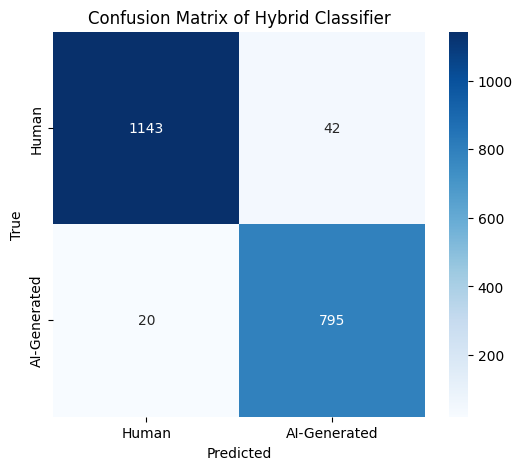

In [18]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for (images, freq_images), labels in tqdm(val_loader, desc="Final Evaluation"):
        images = images.to(device)
        freq_images = freq_images.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = model(images, freq_images)
        predicted = (outputs > 0.5).float()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Final accuracy
final_accuracy = 100. * np.mean(all_preds == all_labels)
print("\n Final Validation Accuracy of Hybrid Classifier : {:.2f}%".format(
    final_accuracy))

# Classification report
class_names = ['Human', 'AI-Generated']
report = classification_report(
    all_labels, all_preds, target_names=class_names, output_dict=True)
report_text = classification_report(
    all_labels, all_preds, target_names=class_names)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_fig = plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix of Hybrid Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")

# wandb log
wandb.log({
    "confusion_matrix of Hybrid Classifier": wandb.Image(cm_fig),
    "classification_report of Hybrid Classifier": wandb.Table(columns=["class", "precision", "recall", "f1-score", "support"],
                                         data=[[k, v["precision"], v["recall"], v["f1-score"], v["support"]]
                                               for k, v in report.items() if k in class_names]),
    "final_val_accuracy of Hybrid Classifier": final_accuracy
})

print("\n Classification Report of Hybrid Classifier:\n")
print(report_text)

wandb.finish()